In [1]:
import sys
sys.path.append('../')
sys.path.append('/usr/users/fsimone/tejaas')

import numpy as np
import collections
import gzip
import random

from scipy import stats
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
from utils import readgtf

# from utils import mpl_stylesheet
# mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

In [22]:
import os, re
from functools import wraps
import time

def timeit(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print('{:s} took: {:.6f} seconds'.format(f.__name__, te-ts))
        return result
    return wrap

SNPINFO_FIELDS = ['chrom', 'varid', 'bp_pos', 'ref_allele', 'alt_allele', 'maf']
class SnpInfo(collections.namedtuple('_SnpInfo', SNPINFO_FIELDS)):
    __slots__ = ()

SNP_COMPLEMENT = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}

def HWEcheck(x):
    gt = x.tolist()
    f = np.array([0] * 3)
    f[0] = gt.count(0)
    f[1] = gt.count(1)
    f[2] = gt.count(2)
    n = sum(f)
    #p_A = (2 * f[0] + f[1]) / (2 * n)
    #p_a = (2 * f[2] + f[1]) / (2 * n)
    X2 = n * ( (4 * f[0] * f[2] - f[1] ** 2) / ((2 * f[0] + f[1]) * (2 * f[2] + f[1])) )**2
    pval = 1 - stats.chi2.cdf(X2, 1)
    return pval


def filter_snps(snpinfo, dosage):
        # Predixcan style filtering of snps
        newsnps = list()
        newdosage = list()
        npoly = 0
        nambi = 0
        nunkn = 0
        nlowf = 0
        nlowf_actual = 0
        nhwep = 0
        maf_limit = 0.01
        for i, snp in enumerate(snpinfo):
            pos = snp.bp_pos
            refAllele = snp.ref_allele
            effectAllele = snp.alt_allele
            rsid = snp.varid
            maf = round(snp.maf, 3)
            maf_actual = sum(dosage[i]) / 2 / len(dosage[i])
            # Skip non-single letter polymorphisms
            if len(refAllele) > 1 or len(effectAllele) > 1:
                npoly += 1
                continue
            # Skip ambiguous strands
            if SNP_COMPLEMENT[refAllele] == effectAllele:
                nambi += 1
                continue
            # Skip unknown RSIDs
            if rsid == '.':
                nunkn += 1
                continue
            # Skip low MAF
            if not (maf >= maf_limit and maf <= (1 - maf_limit)):
                nlowf += 1
                continue
            if not (maf_actual >= maf_limit and maf_actual <= (1 - maf_limit)):
                nlowf_actual += 1
                continue
            # if np.all(dosage[i] == dosage[i][0:]):
            #     nsame += 1
            #     continue
            # # Convert to integers 0, 1 or 2
            # bins = [0.66, 1.33]
            # intdosage = np.digitize(dosage[i], bins)
            # # Remove SNPs out of HWE
            # hwep = self.HWEcheck(intdosage)
            # if(hwep < 0.000001):
            #    nhwep += 1
            #    # self.logger.debug("SNP {:s} has a HWE p-value of {:g}".format(rsid, hwep))
            #    continue
            new_snp = snp._replace(maf = maf_actual)
            newsnps.append(new_snp)
            newdosage.append(dosage[i])
            # newdosage.append(intdosage)
        print("Removed {:d} SNPs because of non-single letter polymorphisms".format(npoly))
        print("Removed {:d} SNPs because of ambiguous strands".format(nambi))
        print("Removed {:d} SNPs because of unknown RSIDs".format(nunkn))
        print("Removed {:d} SNPs because of low MAF < {:g}".format(nlowf, maf_limit))
        print("Removed {:d} SNPs because of low MAF (current)".format(nlowf_actual))
        return newsnps, np.array(newdosage)   

def read_vcf(filename, startsnp, endsnp, mode="DS", samplefile=None):
    dosage = list()
    snpinfo = list()
    linenum = 0
    with gzip.open(filename, 'r') as vcf:
        for line in vcf:
            linestrip = line.decode().strip()
            if linestrip[:2] == '##': continue
            if linestrip[:6] == '#CHROM':
                linesplit = linestrip.split("\t")
                donor_ids = linesplit[9:]
            else:
                if linenum >= startsnp and linenum < endsnp:
                    linesplit = linestrip.split("\t")
                    if linesplit[0].startswith("chr"):
                        chrom = int(linesplit[0][3:])
                    else:
                        chrom = int(linesplit[0])
                    pos   = int(linesplit[1])
                    varid = linesplit[2]
                    ref   = linesplit[3]
                    alt   = linesplit[4]

                    if mode == "DS":
                        if "DS" not in linesplit[8].split(':'):
                            mode = "GT"
                        else:
                            dsindx = linesplit[8].split(':').index("DS")
                            ds = [x.split(':')[dsindx] for x in linesplit[9:]]
                            gtindx = linesplit[8].split(':').index("GT")
                            for i, x in enumerate(ds):
                                if x == ".":
                                    gt = linesplit[9+i].split(':')[gtindx]
                                    if len(gt) == 3 and gt[0] != "." and gt[2] != ".":
                                        ds[i] = float(int(gt[0]) + int(gt[2]))

                    if mode == "GT":
                        if "GT" not in linesplit[8].split(':'):
                            print("ERROR: no GT field in VCF file")
                            raise
                        gtindx = linesplit[8].split(':').index("GT")
                        gt = [x.split(':')[gtindx] for x in linesplit[9:]]
                        ds = [ float(int(x[0]) + int(x[2])) if len(x) == 3 and x[0] != "." and x[2] != "." else "." for x in gt ]

                    ds_notna = [float(x) for x in ds if x != "."]
                    freq = sum(ds_notna) / 2 / len(ds_notna)
                    maf = freq
                    snpdosage = [float(x) if x != '.' else 2 * freq for x in ds]

                    this_snp = SnpInfo(chrom      = chrom,
                                       bp_pos     = pos,
                                       varid      = varid,
                                       ref_allele = ref,
                                       alt_allele = alt,
                                       maf        = maf)

                    dosage.append(snpdosage)
                    snpinfo.append(this_snp)
                linenum += 1
                
                if linenum > endsnp:
                    break
                    
    if samplefile is not None:
        if os.path.exists(samplefile):
            with open(samplefile, 'r') as samfile:
                sample = 0
                samplenames = list()
                next(samfile)
                next(samfile)
                for line in samfile:
                    if re.search('^#', line):
                        continue
                    samplenames.append(line.strip().split()[0])
            common_ids = [x for x in samplenames if x in donor_ids]
            print("GT Sample selection {:d} samples were retained from a total of {:d} samples".format(len(common_ids), len(donor_ids)))
            ix = [donor_ids.index(x) for x in common_ids]
            return np.array(dosage)[:,ix], snpinfo, common_ids
        else:
            print("samplefile does not exist")
            raise
    else:
        return np.array(dosage), snpinfo, donor_ids


def normalize_expr(Y):
    if isinstance(Y, pd.DataFrame):
        Y_cent = (Y.values - np.mean(Y.values, axis = 1).reshape(-1, 1)) / np.std(Y.values, axis = 1).reshape(-1, 1)
        Y_cent = pd.DataFrame(Y_cent, index=Y.index, columns=Y.columns)
        Y_cent.index.name = Y.index.name
    else:
        Y_cent = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return Y_cent

def select_donors(vcf_donors, expr_donors):
    ''' Make sure that donors are in the same order for both expression and genotype
    '''
    common_donors = [x for x in vcf_donors if x in expr_donors]
    vcfmask = np.array([vcf_donors.index(x) for x in common_donors])
    exprmask = np.array([expr_donors.index(x) for x in common_donors])
    return vcfmask, exprmask

def select_genes(info, names):
    ''' Select genes which would be analyzed. 
        Make sure the indices are not mixed up
    '''
    allowed = [x.ensembl_id for x in info]
    common  = [x for x in names if x in allowed]
    genes = [x for x in info if x.ensembl_id in common]
    indices = [names.index(x.ensembl_id) for x in genes]
    return genes, np.array(indices)

def normalize_and_center_dosage(dosage, snpinfo):
    f = [snp.maf for snp in snpinfo]
    f = np.array(f).reshape(-1, 1)
    gtnorm = (dosage - (2 * f)) / np.sqrt(2 * f * (1 - f))
    gtcent = dosage - np.mean(dosage, axis = 1).reshape(-1, 1)
    return gtnorm, gtcent #rr uses gtcent

def sample_gt(snpinfo, nsample):
    nsnps = len(snpinfo)
    dosages = np.zeros(nsnps * nsample)
    i = 0
    for snp in snpinfo:
        gtcent = sample_from_maf(nsample, snp.maf)
        dosages[i,:] = gtcent
        i += 1
    return dosages    

def sample_from_maf(nsample, maf):
    dosage = np.zeros(nsample)
    mafratios = np.array([(1 - maf)**2, 2 * maf * (1 - maf), maf**2])
    nfreq  = np.random.multinomial(nsample, mafratios, size=1)[0]
    f1 = np.repeat(0, nfreq[0])
    f2 = np.repeat(1, nfreq[1])
    f3 = np.repeat(2, nfreq[2])
    x  = np.concatenate((f1,f2,f3))
    dosage = np.random.permutation(x)
    # gtnorm = (dosage - (2 * maf2d)) / np.sqrt(2 * maf2d * (1 - maf2d))
    gtcent = dosage - np.mean(dosage)

    return gtcent

def simulate_gt(nsnps, nsample):
    mafs = np.linspace(0.1, 0.9, nsnps)
    gtcent = np.zeros((nsnps, nsample))
    snpinfo = list()
    for i in range(nsnps):
        gtcent[i,:] = sample_from_maf(nsample, mafs[i])
        this_snp = SnpInfo(chrom      = 1,
                           bp_pos     = i*100,
                           varid      = "rsid"+str(i),
                           ref_allele = "A",
                           alt_allele = "G",
                           maf        = mafs[i])
        snpinfo.append(this_snp)
    return gtcent, snpinfo

CISMASK_FIELDS = ['rmv_id', 'apply2']
class CisMask(collections.namedtuple('_CisMask', CISMASK_FIELDS)):
    __slots__ = ()

    @property
    def nsnp(self):
        return len(self.apply2)

    def __repr__(self):
        parent_string = super(CisMask, self).__repr__()
        return '{:s}, nsnp = {:d}'.format(parent_string, self.nsnp)

def get_cismasklist(snpinfo, geneinfo, chrom, window=1e6):
    chr_genes_ix = [[] for ichrm in range(22)] 
    chr_genes = [[] for ichrm in range(22)]
    if chrom is not None:
        chr_genes_ix[chrom - 1] = np.array([i for i, g in enumerate(geneinfo) if g.chrom == chrom])
        chr_genes[chrom - 1] = [geneinfo[ix] for ix in chr_genes_ix[chrom - 1]]
    else:
        for ichrm in range(22):
            chr_genes_ix[ichrm] = np.array([i for i, g in enumerate(geneinfo) if g.chrom == ichrm + 1])
            chr_genes[ichrm] = [geneinfo[ix] for ix in chr_genes_ix[ichrm]]
    genemasks = list()
    iprev = 0
    ichrmprev = 0
    for snp in snpinfo:
        pos = snp.bp_pos
        left = pos - window
        right = pos + window
        ichrm = chrom - 1 if chrom is not None else snp.chrom - 1
        iprev_started = False
        if ichrm != ichrmprev:
            iprev = 0
            ichrmprev = ichrm
        thismask = list()
        for i, g in enumerate(chr_genes[ichrm][iprev:]):
            gstart = g.start
            gend = g.end
            if gstart >= left and gstart <= right:
                # thismask.append(iprev + i)
                thismask.append(chr_genes_ix[ichrm][iprev + i])
                if not iprev_started:
                    new_start_iloc = iprev
                    iprev_started = True
            elif gend >= left and gend <= right:
                # thismask.append(iprev + i)
                thismask.append(chr_genes_ix[ichrm][iprev + i])
                if not iprev_started:
                    new_start_iloc = iprev
                    iprev_started = True
            if gstart > right:
                break
        if len(thismask) > 0:
            #genemasks.append(chr_genes_ix[np.array(thismask)])
            #iprev = thismask[0]
            genemasks.append(np.array(thismask))
            iprev = new_start_iloc
        else:
            genemasks.append(np.array([]))
    return genemasks

def compress_cismasklist(genemasks):
    cismasks = list()
    appendmask = False
    endmask = False
    setprev = False
    snplist = list()
    for i, mask in enumerate(genemasks):
        if not setprev:
            prev_mask = mask
            setprev = True
        if np.all(np.array_equal(mask, prev_mask)):
            snplist.append(i)
        else:
            appendmask = True

        if i == len(genemasks) - 1: endmask = True # no more masks to process

        if appendmask:
            thismask = CisMask(rmv_id = prev_mask, apply2 = snplist)
            cismasks.append(thismask)
            snplist = list([i])
            prev_mask = mask
            if not endmask:
                appendmask = False

        if endmask:
            # if not appendmask:
            #     snplist.append(i)
            thismask = CisMask(rmv_id = mask, apply2 = snplist)
            cismasks.append(thismask)

    return cismasks

def knn_correction(expr, dosage, K, f=1):
    assert (expr.shape[0] == dosage.shape[1])
    pca = PCA(n_components=int(f * min(expr.shape[0], expr.shape[1]) ))
#     print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
#     print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    gt_knn = np.zeros_like(dosage)
    neighbor_list = list()

    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        gt_knn[:, i] = dosage[:, i] - np.mean(dosage[:, noisy_neighbors], axis = 1)
        neighbor_list.append(neighbors)

    return gx_knn, gt_knn

# # PCA correction - Won't work: makes some singular values == 0
def PCA_correction(gx, nComp = 5):
    pca = PCA()
    pca.fit(gx.T)
    gx_pca = np.dot(pca.transform(gx.T)[:, nComp:], pca.components_[nComp:,:]).T
    gx_pca_norm = normalize_expr(gx_pca)
    return gx_pca_norm

In [3]:
gencode_file = "/cbscratch/franco/datasets/GENCODE/gencode.v26.annotation.gtf.gz"
geneinfo = readgtf.gencode_v12(gencode_file, biotype = ["protein_coding", "lncRNA"])

Mode v26


In [4]:
# # Simulate some expression
# ngene = 15000
# nsample = 350
# gx_rand = np.random.normal(0, 1, size = nsample * ngene).reshape((ngene, nsample)) 
# gx_donors = random.sample(gt_donors, nsample)
# print(gx_rand.shape)

# Load real expression
import pandas as pd
tissue="as"
# - No corrections
df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue), header=0, index_col=0, sep="\t")

# pub data reminder
# df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess_nov2019_pub/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue), header=0, index_col=0, sep="\t")
ngene, nsample = df.shape
gx_donors = list(df.columns)
gx = df.values
gene_names = list(df.index)
print(gx.shape)
print("Matrix rank:", np.linalg.matrix_rank(gx))


(15673, 581)
Matrix rank: 580


In [33]:
# Use real genotype
chrm=12
f_vcf = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/0.01/GTEX_v8_2020-02-21_WGS_838Indiv_Freeze.SHAPEIT2_phased_NoMissingGT_SNPfilter_MAF0.01_chr{:d}.vcf.gz".format(chrm)
# samplefile = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur.sample"
samplefile = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8.sample"
gtfull, snpinfos, gt_donors = read_vcf(f_vcf, 0, 100, samplefile=samplefile)

import copy
vcfmask, exprmask = select_donors(gt_donors, gx_donors)
genes, indices = select_genes(geneinfo, gene_names)
dosage_masked = gtfull[:, vcfmask]

snp_info, dosage = filter_snps(snpinfos, dosage_masked)

# Use artificial genotype
# gtfull, snp_info = simulate_gt(10000, len(gt_donors))


GT Sample selection 838 samples were retained from a total of 838 samples
Removed 0 SNPs because of non-single letter polymorphisms
Removed 0 SNPs because of ambiguous strands
Removed 0 SNPs because of unknown RSIDs
Removed 0 SNPs because of low MAF < 0.01
Removed 4 SNPs because of low MAF (current)


In [34]:
gx_norm = normalize_expr( gx[:, exprmask][indices,:] )
nsample = gx_norm.shape[1]

print(gx_norm.shape)

## --- Apply KNN correction
f=1
gx_knn, gt_knn = knn_correction(gx_norm.T, dosage, K=30, f=f)

## --- Normalize GX and GT
gt_norm, gt_cent = normalize_and_center_dosage(dosage, snp_info)
sigmax2     = np.var(gt_cent, axis = 1)

gx_knn_norm = normalize_expr(gx_knn.T)
gt_knn_norm, gt_knn_cent = normalize_and_center_dosage(gt_knn, snp_info)
sigmax2_knn = np.var(gt_knn_cent, axis = 1)

shuffle_mask = np.arange(nsample)
np.random.shuffle(shuffle_mask)
gx_shuffled_norm = copy.deepcopy(gx_norm[:, shuffle_mask])
gx_shuffled_knn_norm = copy.deepcopy(gx_knn_norm[:, shuffle_mask])

(15673, 581)
581 581 ?


In [35]:
## --- Obtain CisMasks

cismasklist = get_cismasklist(snp_info, genes, chrm, window=1e6)
cismaskcomp = compress_cismasklist(cismasklist)

In [36]:
# Y = gx_knn_norm # / np.sqrt(nsample)
# Yt = Y.T
# U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
# s2_median = np.median(np.square(S))
# s2_10     = np.percentile(np.square(S), 10)
# print(s2_median)
# print(s2_10)
# SIGMA_BETAS = np.repeat(0.05, gt_cent.shape[0])
# DY_SIGMA_BETAS = np.sqrt( sigmax2_knn / s2_median )
# DY_SIGMA_BETAS10 = np.sqrt( sigmax2_knn / s2_10 )
# plt.hist(DY_SIGMA_BETAS, alpha=0.4, label="median")
# plt.hist(DY_SIGMA_BETAS10, alpha=0.4, label="percentile")
# plt.legend()
# plt.show()

# # SIGMA_BETAS = DY_SIGMA_BETAS10
# SIGMA_BETAS = DY_SIGMA_BETAS

In [37]:
### Optimizes sb2 to a given Keff

# @timeit
# def optimize_sb2(S, sigmasx, target):
#     sbetas = list()
#     S2 = np.square(S)
#     S2_lim = np.percentile(S2, 50)
#     for sx2 in sigmasx:
#         sb2 =  sx2 / S2_lim       # start parameter at median
#         S2mod = S2 + (sx2 / sb2)
#         N = len(S2)
#         Keff = np.sum(S2/S2mod) / N

#         while np.abs(Keff - target) > 0.01:
#             diff = Keff - target
#             sb2 -= diff*(sb2)
#             S2mod = S2 + (sx2 / sb2)
#             Keff = np.sum(S2/S2mod) / N
#         #print("Keff",Keff)
#         #print("SB2=",sb2)
#         sbetas.append(sb2)
#     return np.array(sbetas)

# Y = gx_norm
# Yt = Y.T
# U, S, Vt = np.linalg.svd(Yt, full_matrices=False)

# sb2_opt_K = optimize_sb2(S, sigmax2, 0.5)

# Y = gx_knn_norm
# Yt = Y.T
# U, S, Vt = np.linalg.svd(Yt, full_matrices=False)

# sb2_opt_K_knn = optimize_sb2(S, sigmax2_knn, 0.5)

In [38]:
def pvals_perm(GT, R, W):
    mu2, mu4 = moment_data(GT)
    N = GT.shape[1]
    q11 = np.sum(W)
    q2  = np.sum(np.diag(W))
    muQ = mu2 * (N * q2 - q11) / (N - 1)

    v31 = - mu4 / (N - 1)
    v22 = v31 + (N * mu2 * mu2 / (N - 1)) #(N*(mu2**2) - mu4)/(N-1)
    v211 = - (v31 + v22) / (N - 2)
    v1111 = - 3 * v211 / (N - 3)

    q31 = np.dot(np.diag(W),np.sum(W,axis = 1))
    q4 = np.sum(np.square(np.diag(W)))
    q22 = np.sum(np.square(W))
    q211 = np.sum(np.square(np.sum(W,axis = 1)))

    sigma2 = v1111*(q11**2 - 2*q2*q11 - 4*q211 + 8*q31 + 2*q22 + q2**2 - 6*q4) + 2*v211*(q2*q11 + 2*q211 - 6*q31 - 2*q22 - q2**2 + 6*q4) + v22*(q2**2 + 2*q22 - 3*q4) + 4*v31*(q31 - q4) + mu4*q4

    sigma2 = sigma2 - muQ**2
    sigmaQ = np.sqrt(sigma2)
    p = 1 - stats.norm.cdf(R, loc=muQ, scale=sigmaQ)
    return p, muQ, sigmaQ

def moment_data(GT):   #GT ixN
    GT2 = np.square(GT)
    GT4 = np.square(GT2)
    mu2 = np.mean(GT2)
    mu4 = np.mean(GT4)
    return mu2, mu4

In [39]:
from scipy.optimize import minimize

class SBoptimizer:

    def __init__(self, GT, GX, sx2):

        self._GT  = np.ascontiguousarray(GT)
        self._GX  = np.ascontiguousarray(GX)
        self._sx2 = np.ascontiguousarray(sx2)
        self._nsnps = GT.shape[0]
        self._nsample = GX.shape[1]
        
        U, S, VT = np.linalg.svd(GX.T)
        self._S = S
        self._U = U
        self._S2 = np.square(S)
        self._opt_sb2 = np.zeros(self._nsnps)
    
    @property
    def sb2(self):
        return self._opt_sb2

    def get_ML(self, _sb2, i):
        # sb2 = sb * sb
        sb2 = np.exp(_sb2)
        S2mod = self._S2 + (self._sx2[i] / sb2)
        Rscore = np.sum(np.square(np.dot(self._U.T, self._GT[i,:])) * (self._S2 / S2mod)) / self._sx2[i]
        MLL = -0.5*np.sum(np.log( self._S2 * (sb2 / self._sx2[i]) + 1 )) + 0.5*Rscore

        denom = (self._S2 * sb2 + self._sx2[i])
        der = 0.5* np.sum( ( self._S2 / denom ) * ( (np.square(np.dot(self._U.T, self._GT[i,:])) / denom ) - 1 ) )
        return -MLL, sb2*np.array([-der])

    def fit(self):
        st = time.time()
        
        sb_init = np.exp(0.01)
        for i in range(self._nsnps):
            res = minimize(   self.get_ML,
                              sb_init, 
                              args = i,
                              method='L-BFGS-B',
                              jac = True,
                              #bounds = [[0,1]],
                              options={'maxiter': 200000,
                                       'maxfun': 2000000,
                                       #'ftol': 1e-9,
                                       #'gtol': 1e-9,
                                       'disp': True})

            # print(res)
            self._opt_sb2[i] = np.exp(res.x[0])
        et = time.time()
        print("optimization took in total: ",et-st)

====== Norm - no KNN ======
Found 1 cismasks.
Processing cismask 0: 15 genes masked for 96 snps
====== Norm Shuffled - no KNN ======
Found 1 cismasks.
Processing cismask 0: 15 genes masked for 96 snps
====== Norm KNN ======
Found 1 cismasks.
Processing cismask 0: 15 genes masked for 96 snps
====== Shuffled Norm KNN ======
Found 1 cismasks.
Processing cismask 0: 15 genes masked for 96 snps


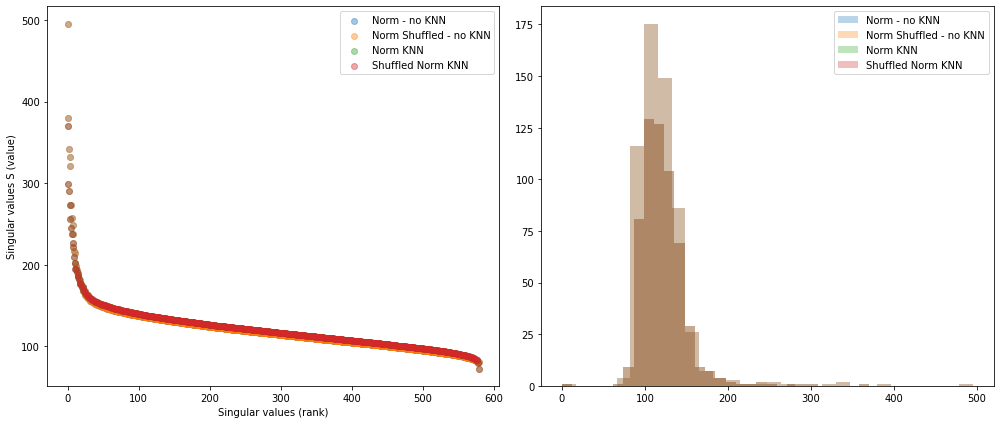

In [40]:
import random

def tejaas_rr(myGT, myGX, sigmax2, sb2):
    nsnps  = myGT.shape[0]
    Rscore = np.zeros(nsnps)
    pvals  = np.zeros(nsnps)
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    Keff   = np.zeros(nsnps)
    EmuQ   = np.zeros(nsnps)
    EsigmaQ= np.zeros(nsnps)
    
    # Yt = (GX / np.sqrt(nsample)).T
    Yt = myGX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    
    for j in range(nsnps):       
        S2mod = S2 + (sigmax2[j] / sb2[j])
        Keff[j] = np.sum(S2/S2mod)
        
        W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2[j]
        Rscore[j] = np.sum(np.square(np.dot(U.T, myGT[j,:])) * (S2 / S2mod)) / sigmax2[j]
        
        pvals[j], muQ[j], sigmaQ[j] = pvals_perm(myGT[j, :].reshape(1, -1), Rscore[j], W)
        
#         rand_gt = copy.deepcopy(myGT[j,:])
#         emp_q = np.zeros(2000)
#         for k in range(2000):
#             random.shuffle(rand_gt)
#             emp_q[k] = np.sum(np.square(np.dot(U.T, rand_gt)) * (S2 / S2mod)) / sigmax2[j]
#         EmuQ[j]     = np.mean(emp_q)
#         EsigmaQ[j]  = np.var(emp_q)
        
        
    return S2, pvals, Rscore, muQ, sigmaQ, Keff #, EmuQ, EsigmaQ

def compare_basic_props(GX, GT, ax1, ax2, label, sigmax2, sb2 = None, cismasks = None):
        
    nsnps  = GT.shape[0]
    Rscore = np.zeros(nsnps)
    pvals  = np.zeros(nsnps)
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    Keff   = np.zeros(nsnps)
    EmuQ   = np.zeros(nsnps)
    EsigmaQ= np.zeros(nsnps)
    myGT = GT
    myGX = GX
    opt_sb2 = np.zeros(nsnps)
    
    print("====== {:s} ======".format(label))
    Yt = myGX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S, dtype=np.float64 )
    
        
    ax1.scatter(np.arange(len(S)-1), S[:-1], label = label, alpha=0.4)
    ax2.hist(S, bins=30, alpha=0.3, label = label)
    
    if cismasks is not None:
        nmasks = len(cismasks)
        print("Found {:d} cismasks.".format(nmasks))
        for i,cismask in enumerate(cismasks):
            print("Processing cismask {:d}: {:d} genes masked for {:d} snps".format(i, len(cismask.rmv_id), cismask.nsnp))
            usegenes = np.ones(GX.shape[0], dtype=bool)
            if cismask.rmv_id.shape[0] > 0: usegenes[cismask.rmv_id] = False
            myGX = GX[usegenes]
            myGT = GT[cismask.apply2,:]
            
#             SBOPT = SBoptimizer(myGT, myGX, sigmax2[cismask.apply2])
#             SBOPT.fit()
#             sb2 = SBOPT.sb2
#             opt_sb2[cismask.apply2] = SBOPT.sb2
            
#             _s2, _pvals, _qscores, _muq, _sigmaq, _keff, _emuq, _esigq = tejaas_rr(myGT, myGX, sigmax2[cismask.apply2], sb2, Z, ZTZ_inv) #[cismask.apply2])
            _s2, _pvals, _qscores, _muq, _sigmaq, _keff = tejaas_rr(myGT, myGX, sigmax2[cismask.apply2], sb2) #[cismask.apply2])
            pvals[cismask.apply2]  = _pvals
            Rscore[cismask.apply2] = _qscores
            muQ[cismask.apply2]    = _muq
            sigmaQ[cismask.apply2] = _sigmaq
            Keff[cismask.apply2]   = _keff
#             EmuQ[cismask.apply2]   = _emuq
#             EsigmaQ[cismask.apply2]= _esigq
            
    else:
        S2, pvals, Rscore, muQ, sigmaQ = tejaas_rr(myGT, myGX, sigmax2, sb2)        
    return S2, pvals, Rscore, muQ, sigmaQ, opt_sb2, Keff #, EmuQ, EsigmaQ

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sb2 = np.repeat(0.1*0.1, gt_cent.shape[0])
# sb2 = sb2_opt_K_knn

# - No KNN
nS2, npvals, nQ, nmuQ, nscaledQ, nopt_sb2, nKeff = compare_basic_props(gx_norm, 
                                                                       gt_cent, 
                                                                       ax1, ax2, 
                                                                       'Norm - no KNN', 
                                                                       sigmax2, 
                                                                       sb2 = sb2, 
                                                                       cismasks=cismaskcomp)
shuf_nS2, shuf_npvals, shuf_nQ, shuf_nmuQ, shuf_nscaledQ, shuf_nopt_sb2, shuf_nKeff = compare_basic_props(gx_shuffled_norm, 
                                                                                                          gt_cent, 
                                                                                                          ax1, ax2, 
                                                                                                          'Norm Shuffled - no KNN', 
                                                                                                          sigmax2, 
                                                                                                          sb2 = sb2, 
                                                                                                          cismasks=cismaskcomp)

# nS2, npvals, nQ, nmuQ, nscaledQ, nopt_sb2, nKeff, nEmuQ, nEscaledQ = compare_basic_props(gx_norm, gt_cent, ax1, ax2, 'Norm - no KNN', sigmax2, Z, ZTZ_inv, sb2 = sb2, cismasks=cismaskcomp)
# shuf_nS2, shuf_npvals, shuf_nQ, shuf_nmuQ, shuf_nscaledQ, shuf_nopt_sb2, shuf_nKeff, shuf_nEmuQ, shuf_nEscaledQ = compare_basic_props(gx_shuffled_norm, gt_cent, ax1, ax2, 'Norm Shuffled - no KNN', sigmax2, Z, ZTZ_inv, sb2 = sb2, cismasks=cismaskcomp)

# - With KNN
# S2, pvals, Q, muQ, scaledQ, opt_sb2, Keff, EmuQ, EscaledQ = compare_basic_props(gx_knn_norm, gt_knn_cent, ax1, ax2, 'Norm KNN', sigmax2 = sigmax2_knn, sb2 = sb2, cismasks=cismaskcomp)
# shuf_S2, shuf_pvals, shuf_Q, shuf_muQ, shuf_scaledQ, shuf_opt_sb2, shuf_Keff, shuf_EmuQ, shuf_EscaledQ  = compare_basic_props(gx_shuffled_knn_norm, gt_knn_cent, ax1, ax2, 'Shuffled Norm KNN', sigmax2 = sigmax2_knn, sb2 = sb2, cismasks=cismaskcomp)
S2, pvals, Q, muQ, scaledQ, opt_sb2, Keff = compare_basic_props(gx_knn_norm, 
                                                                gt_knn_cent, 
                                                                ax1, ax2, 
                                                                'Norm KNN', 
                                                                sigmax2_knn, 
                                                                sb2 = sb2, 
                                                                cismasks=cismaskcomp)
shuf_S2, shuf_pvals, shuf_Q, shuf_muQ, shuf_scaledQ, shuf_opt_sb2, shuf_Keff = compare_basic_props(gx_shuffled_knn_norm, 
                                                                                                   gt_knn_cent, 
                                                                                                   ax1, ax2, 
                                                                                                   'Shuffled Norm KNN', 
                                                                                                   sigmax2_knn, 
                                                                                                   sb2 = sb2, 
                                                                                                   cismasks=cismaskcomp)

# # # - With KNN
# S260, pvals60, Q60, muQ60, scaledQ60 = compare_basic_props(gx_knn_norm60, gt_knn_cent60, ax1, ax2, 'Norm KNN 60', sigmax2 = sigmax2_knn60, sb2 = sb2, cismasks=cismaskcomp)
# shuf_S260, shuf_pvals60, shuf_Q60, shuf_muQ60, shuf_scaledQ60 = compare_basic_props(gx_shuffled_knn_norm60, gt_knn_cent60, ax1, ax2, 'Shuffled Norm KNN 60', sigmax2 = sigmax2_knn60, sb2 = sb2, cismasks=cismaskcomp)

# # - With KNN
# S215, pvals15, Q15, muQ15, scaledQ15 = compare_basic_props(gx_knn_norm15, gt_knn_cent15, ax1, ax2, 'Norm KNN15', sigmax2 = sigmax2_knn15, sb2 = sb2, cismasks=cismaskcomp)
# shuf_S215, shuf_pvals15, shuf_Q15, shuf_muQ15, shuf_scaledQ15 = compare_basic_props(gx_shuffled_knn_norm15, gt_knn_cent15, ax1, ax2, 'Shuffled Norm KNN15', sigmax2 = sigmax2_knn15, sb2 = sb2, cismasks=cismaskcomp)

ax1.set_xlabel("Singular values (rank)")
ax1.set_ylabel("Singular values S (value)")
ax1.legend()

ax2.legend()
plt.tight_layout()
plt.show()


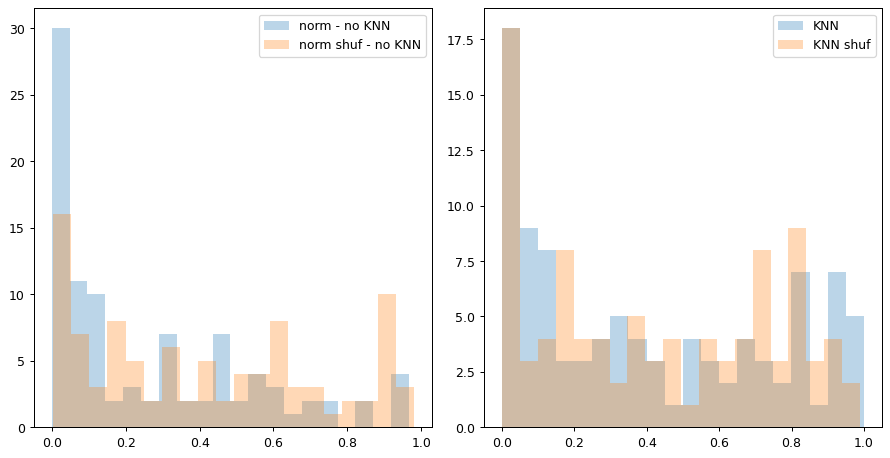

In [41]:
fig = plt.figure(figsize=(10,10), dpi=90)
ax1 = fig.add_subplot(2,2,1)
ax1.hist(npvals, bins=20, alpha=0.3, label="norm - no KNN")
ax1.hist(shuf_npvals, bins=20, alpha=0.3, label="norm shuf - no KNN")
ax1.legend()

ax2 = fig.add_subplot(2,2,2)
ax2.hist(pvals, bins=20, alpha=0.3, label="KNN")
ax2.hist(shuf_pvals, bins=20, alpha=0.3, label="KNN shuf")
ax2.legend()

plt.tight_layout()
plt.show()

In [42]:
pvals

array([9.47479609e-01, 5.96333019e-01, 1.23265136e-05, 3.32856982e-01,
       1.68700459e-02, 9.67465238e-01, 8.76739784e-02, 7.76330636e-01,
       5.26565137e-01, 4.17795747e-01, 9.68078344e-01, 9.53570574e-02,
       7.73852897e-01, 5.29738578e-02, 3.82016395e-01, 9.49459429e-01,
       1.35162126e-03, 3.62519168e-02, 2.10530627e-01, 9.99774434e-01,
       4.75976716e-01, 9.16105272e-01, 4.22560350e-01, 6.85168877e-01,
       6.16090038e-01, 1.08718333e-01, 8.21138622e-01, 7.26456790e-01,
       5.68538671e-01, 9.07513988e-01, 1.08718333e-01, 9.83123224e-02,
       1.08718333e-01, 9.43268007e-01, 4.48184308e-01, 3.00320280e-01,
       9.14819373e-02, 6.16090038e-01, 1.54071844e-02, 1.07284814e-01,
       9.57873467e-02, 8.46119071e-01, 7.42887547e-01, 5.42329414e-01,
       1.08718333e-01, 8.51976023e-01, 9.17159936e-01, 5.23873740e-01,
       2.52711865e-01, 7.23145032e-01, 1.08718333e-01, 6.58486273e-01,
       2.76893574e-02, 9.56609333e-01, 8.29678218e-01, 6.66946853e-01,
      

In [43]:
snp_info

[SnpInfo(chrom=12, varid='chr12_10674_G_A_b38', bp_pos=10674, ref_allele='G', alt_allele='A', maf=0.012908777969018933),
 SnpInfo(chrom=12, varid='chr12_10700_G_A_b38', bp_pos=10700, ref_allele='G', alt_allele='A', maf=0.014629948364888123),
 SnpInfo(chrom=12, varid='chr12_11236_C_T_b38', bp_pos=11236, ref_allele='C', alt_allele='T', maf=0.06282271944922548),
 SnpInfo(chrom=12, varid='chr12_11702_A_C_b38', bp_pos=11702, ref_allele='A', alt_allele='C', maf=0.016351118760757316),
 SnpInfo(chrom=12, varid='chr12_12026_G_A_b38', bp_pos=12026, ref_allele='G', alt_allele='A', maf=0.08605851979345955),
 SnpInfo(chrom=12, varid='chr12_14301_G_A_b38', bp_pos=14301, ref_allele='G', alt_allele='A', maf=0.0189328743545611),
 SnpInfo(chrom=12, varid='chr12_14769_G_A_b38', bp_pos=14769, ref_allele='G', alt_allele='A', maf=0.029259896729776247),
 SnpInfo(chrom=12, varid='chr12_14826_G_A_b38', bp_pos=14826, ref_allele='G', alt_allele='A', maf=0.22030981067125646),
 SnpInfo(chrom=12, varid='chr12_14888

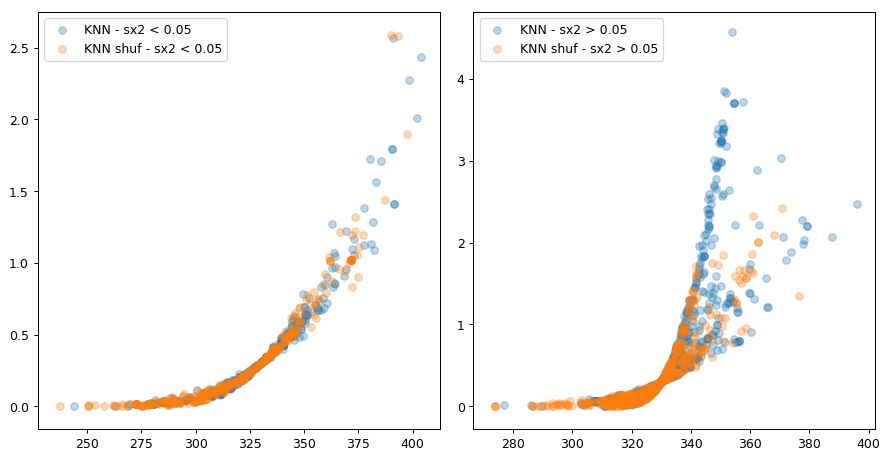

In [306]:
fig = plt.figure(figsize=(10,10), dpi=90)

sx2_lim = 0.05
ix_sx2 = sigmax2_knn <= sx2_lim
ix2_sx2 = sigmax2_knn > sx2_lim

ax1 = fig.add_subplot(2,2,1)
ax1.scatter(Q[ix_sx2], -np.log10(pvals[ix_sx2]), alpha=0.3, label="KNN - sx2 < {:g}".format(sx2_lim))
ax1.scatter(shuf_Q[ix_sx2], -np.log10(shuf_pvals[ix_sx2]), alpha=0.3, label="KNN shuf - sx2 < {:g}".format(sx2_lim))
ax1.legend()
# ax1.set_xlim(200,400)
# ax1.set_ylim(0,5)

ax2 = fig.add_subplot(2,2,2)
ax2.scatter(Q[ix2_sx2], -np.log10(pvals[ix2_sx2]), alpha=0.3, label="KNN - sx2 > {:g}".format(sx2_lim))
ax2.scatter(shuf_Q[ix2_sx2], -np.log10(shuf_pvals[ix2_sx2]), alpha=0.3, label="KNN shuf - sx2 > {:g}".format(sx2_lim))
ax2.legend()
# ax2.set_xlim(200,400)
# ax2.set_ylim(0,5)

plt.tight_layout()
plt.show()

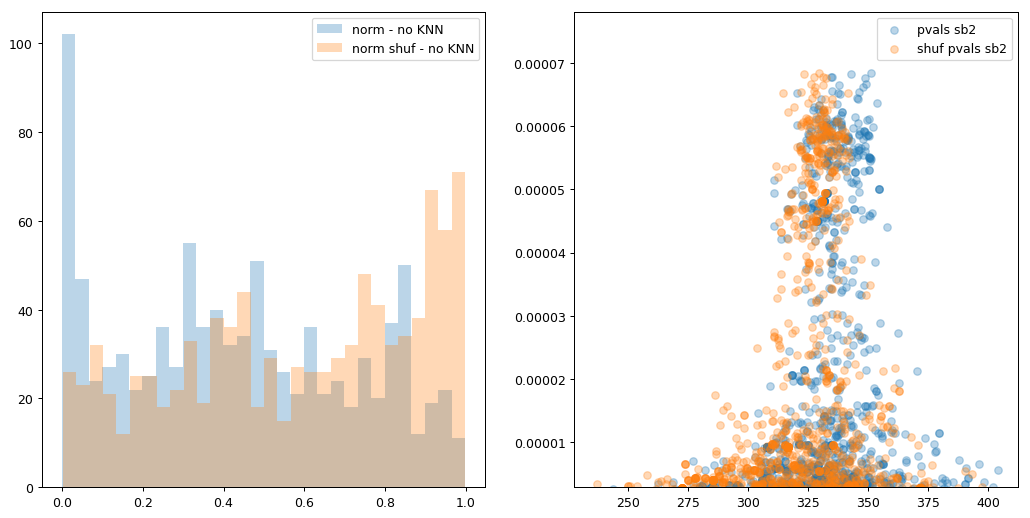

In [307]:
fig = plt.figure(figsize=(14,7), dpi=90)
ax1 = fig.add_subplot(1,2,1)
ax1.hist(pvals, bins=30, alpha=0.3, label="norm - no KNN")
ax1.hist(shuf_pvals, bins=30, alpha=0.3, label="norm shuf - no KNN")
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.scatter( Q, sb2_opt_K_knn, alpha=0.3, label="pvals sb2")
ax2.scatter( shuf_Q, sb2_opt_K_knn, alpha=0.3, label="shuf pvals sb2")
ax2.set_ylim(min(sb2_opt_K), max(sb2_opt_K))
ax2.legend()

plt.show()

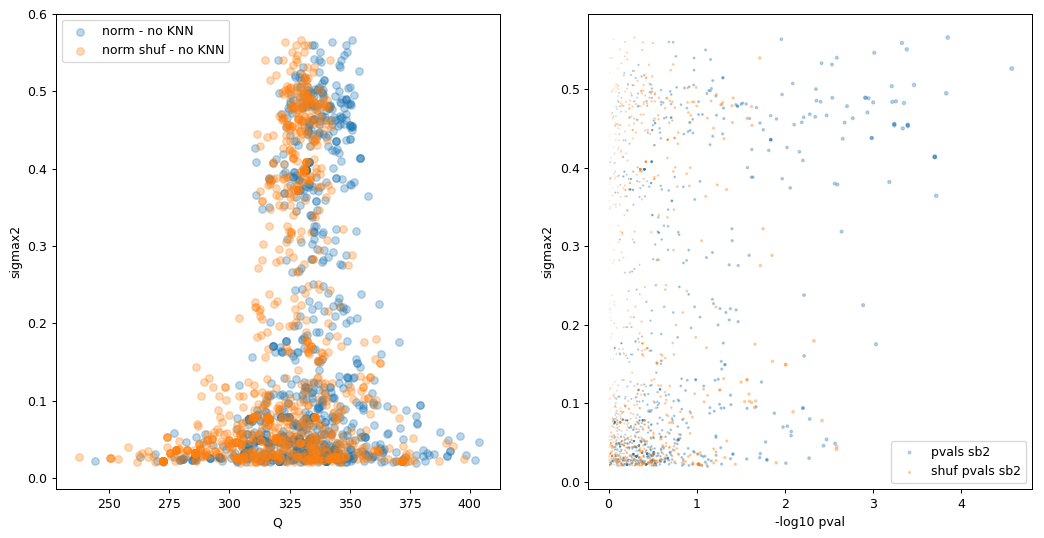

In [308]:
mafs = np.array([snp.maf for snp in snp_info])

fig = plt.figure(figsize=(14,7), dpi=90)
ax1 = fig.add_subplot(1,2,1)
ax1.scatter( Q, sigmax2_knn, alpha=0.3, label="norm - no KNN")
ax1.scatter( shuf_Q, sigmax2_knn, alpha=0.3, label="norm shuf - no KNN")
ax1.set_ylabel("sigmax2")
ax1.set_xlabel("Q")
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.scatter( -np.log10(pvals), sigmax2_knn, s=-np.log10(pvals)*2, alpha=0.3, label="pvals sb2")
ax2.scatter( -np.log10(shuf_pvals), sigmax2_knn, s=-np.log10(shuf_pvals)*2, alpha=0.3, label="shuf pvals sb2")
ax2.set_ylabel("sigmax2")
ax2.set_xlabel("-log10 pval")
ax2.legend()

plt.show()

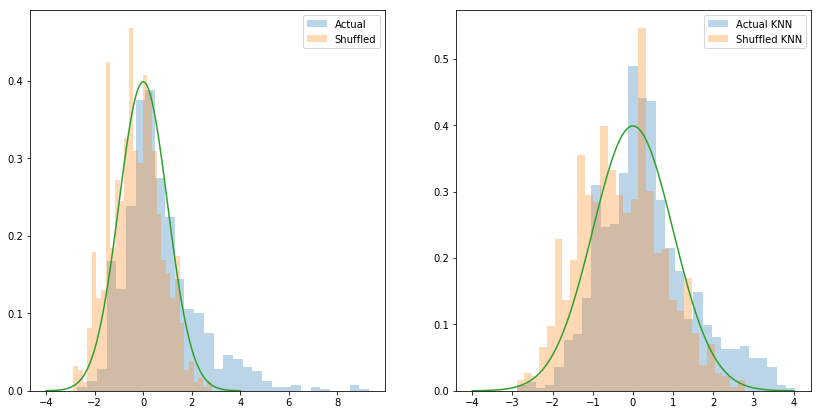

In [309]:
# - no KNN
qscaled = (nQ - nmuQ)/ nscaledQ
shuf_qscaled = (shuf_nQ - shuf_nmuQ)/ shuf_nscaledQ

# - KNN 30
qscaled_knn = (Q - muQ)/ scaledQ
shuf_qscaled_knn = (shuf_Q - shuf_muQ)/ shuf_scaledQ

# - KNN 15
# qscaled = (Q15 - muQ15)/ scaledQ15
# shuf_qscaled = (shuf_Q15 - shuf_muQ15)/ shuf_scaledQ15

# - KNN 60
# qscaled2 = (Q60 - muQ60)/ scaledQ60
# shuf_qscaled2 = (shuf_Q60 - shuf_muQ60)/ shuf_scaledQ60

fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)
ax1.hist(qscaled, bins=30, alpha=0.3, density=True, label="Actual")
ax1.hist(shuf_qscaled, bins=30, alpha=0.3, density=True, label="Shuffled")
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.hist(qscaled_knn, bins=30, alpha=0.3, density=True, label="Actual KNN")
ax2.hist(shuf_qscaled_knn, bins=30, alpha=0.3, density=True, label="Shuffled KNN")
ax2.legend()

x = np.linspace(-4, 4, 100)
rv = stats.norm(loc = 0, scale = 1)
ax1.plot(x, rv.pdf(x), label = 'analytical')
ax2.plot(x, rv.pdf(x), label = 'analytical')

plt.show()

# Single SNP Q distribution

In [327]:
Y = gx_knn_norm
Yt = Y.T
U, S, Vt = np.linalg.svd(Yt, full_matrices=False)

sb2_opt_K_knn = optimize_sb2(S, sigmax2_knn, 0.6)

def tejaas_rr_single_SNP(myGT, myGX, sigmax2, sb2, j):
    it = 10000
    nsnps  = myGT.shape[0]
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    Keff   = np.zeros(nsnps)
    randQ  = np.zeros(it)
    
    Yt = myGX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    
    S2mod = S2 + (sigmax2 / sb2)
    Keff = np.sum(S2/S2mod)

    W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2
    Rscore = np.sum(np.square(np.dot(U.T, myGT[j,:])) * (S2 / S2mod)) / sigmax2

    pval, muQ, sigmaQ = pvals_perm(myGT[j, :].reshape(1, -1), Rscore, W)

    rand_gt = copy.deepcopy(myGT[j,:])
    for k in range(it):
        random.shuffle(rand_gt)
        randQ[k] = np.sum(np.square(np.dot(U.T, rand_gt)) * (S2 / S2mod)) / sigmax2      
        
    return pval, Rscore, muQ, sigmaQ, Keff, randQ

def shuffle_single_snp(GX, GT, label, sigmax2, sb2 = None, cismasks = None):
    nsnps  = GT.shape[0]
    Rscore = np.zeros(nsnps)
    pvals  = np.zeros(nsnps)
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    Keff   = np.zeros(nsnps)
    EmuQ   = np.zeros(nsnps)
    EsigmaQ= np.zeros(nsnps)
    myGT = GT
    myGX = GX
    opt_sb2 = np.zeros(nsnps)
    
    print("====== {:s} ======".format(label))
    Yt = myGX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S, dtype=np.float64 )
        
    if cismasks is not None:
        nmasks = len(cismasks)
        print("Found {:d} cismasks.".format(nmasks))
        for i,cismask in enumerate(cismasks):
            print("Processing cismask {:d}: {:d} genes masked for {:d} snps".format(i, len(cismask.rmv_id), cismask.nsnp))
            usegenes = np.ones(GX.shape[0], dtype=bool)
            if cismask.rmv_id.shape[0] > 0: usegenes[cismask.rmv_id] = False
            myGX = GX[usegenes]
            myGT = GT[cismask.apply2,:]
            
#             SBOPT = SBoptimizer(myGT, myGX, sigmax2[cismask.apply2])
#             SBOPT.fit()
#             sb2 = SBOPT.sb2
#             opt_sb2[cismask.apply2] = SBOPT.sb2
            
            # Select SNP here based on..
            j = np.argsort(sigmax2)[0]
            print("Selected SNP {:d} with sb2: {:g}".format(j, sb2[j]))
            pvals, Q, muQ, sigmaQ, Keff, randQ = tejaas_rr_single_SNP(myGT, myGX, sigmax2[cismask.apply2][j], sb2[j], j)
            print("Keff: {:g}".format(Keff))
            print("Matrix rank: {:d} / {:d}".format(np.sum(S > 1), myGX.shape[1]))
            print("Pvals:",pvals)
            print("SX2:", sigmax2[j])
    else:
        print("failed to provide cismask")
        raise
    return pvals, Q, muQ, sigmaQ, opt_sb2, Keff, randQ

pvals, Q, muQ, sigmaQ, opt_sb2, Keff, randQ               = shuffle_single_snp( gx_knn_norm, 
                                                                                gt_knn_cent,
                                                                                "Norm, KNN",
                                                                                sigmax2_knn,
                                                                                sb2 = sb2_opt_K_knn,
                                                                                cismasks=cismaskcomp)

# s_pvals, s_Q, s_muQ, s_sigmaQ, s_opt_sb2, s_Keff, s_randQ = shuffle_single_snp( gx_shuffled_knn_norm, 
#                                                                                 gt_knn_cent,
#                                                                                 "Norm, KNN - Shuffled",
#                                                                                 sigmax2_knn,
#                                                                                 sb2 = sb2_opt_K_knn,
#                                                                                 cismasks=cismaskcomp)


optimize_sb2 took: 0.365608 seconds
====== Norm, KNN ======
Found 1 cismasks.
Processing cismask 0: 11 genes masked for 965 snps
Selected SNP 939 with sb2: 5.06396e-06
Keff: 429.822
Matrix rank: 669 / 670
Pvals: 0.1468198135770854
SX2: 0.01953516992153659


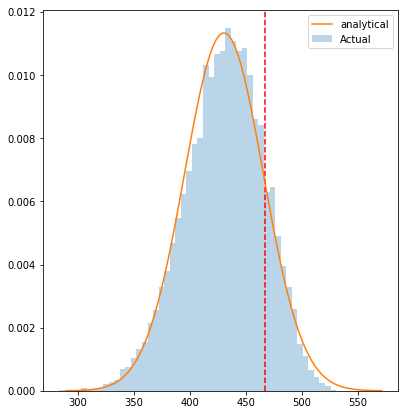

In [328]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)
ax1.hist(randQ, bins=50, alpha=0.3, density=True, label="Actual")
ax1.axvline(Q, linestyle="--", color="red")

x = np.linspace(muQ-4*sigmaQ, muQ+4*sigmaQ, 100)
rv = stats.norm(loc = muQ, scale = sigmaQ)
ax1.plot(x, rv.pdf(x), label = 'analytical')
ax1.legend()

# ax2 = fig.add_subplot(122)
# ax2.hist(s_randQ, bins=50, alpha=0.3, density=True, label="Shuffled")
# ax2.axvline(s_Q, linestyle="--", color="red")

# x = np.linspace(s_muQ-4*s_sigmaQ, s_muQ+4*s_sigmaQ, 100)
# rv = stats.norm(loc = s_muQ, scale = s_sigmaQ)
# ax2.plot(x, rv.pdf(x), label = 'analytical')
# ax2.legend()

plt.show()

====== Norm, KNN ======
optimize_sb2 took: 0.165851 seconds
Found 1 cismasks.
Processing cismask 0: 11 genes masked for 965 snps
Selected SNP 939 with sb 0.001537436703280166
Keff: 0.5 | pval: 0.07541865861764929 | Q:377.4605367688763 | sx2:0.01953516992153659
optimize_sb2 took: 0.304865 seconds
Found 1 cismasks.
Processing cismask 0: 11 genes masked for 965 snps
Selected SNP 939 with sb 0.0019628867151610767
Keff: 0.6 | pval: 0.11731666704357124 | Q:437.4074172979174 | sx2:0.01953516992153659
optimize_sb2 took: 0.427524 seconds
Found 1 cismasks.
Processing cismask 0: 11 genes masked for 965 snps
Selected SNP 939 with sb 0.0025922730771825
Keff: 0.7 | pval: 0.18315255042661815 | Q:495.17127266457453 | sx2:0.01953516992153659
optimize_sb2 took: 0.560221 seconds
Found 1 cismasks.
Processing cismask 0: 11 genes masked for 965 snps
Selected SNP 939 with sb 0.003636336371330813
Keff: 0.8 | pval: 0.3010903344939586 | Q:547.3869134365083 | sx2:0.01953516992153659


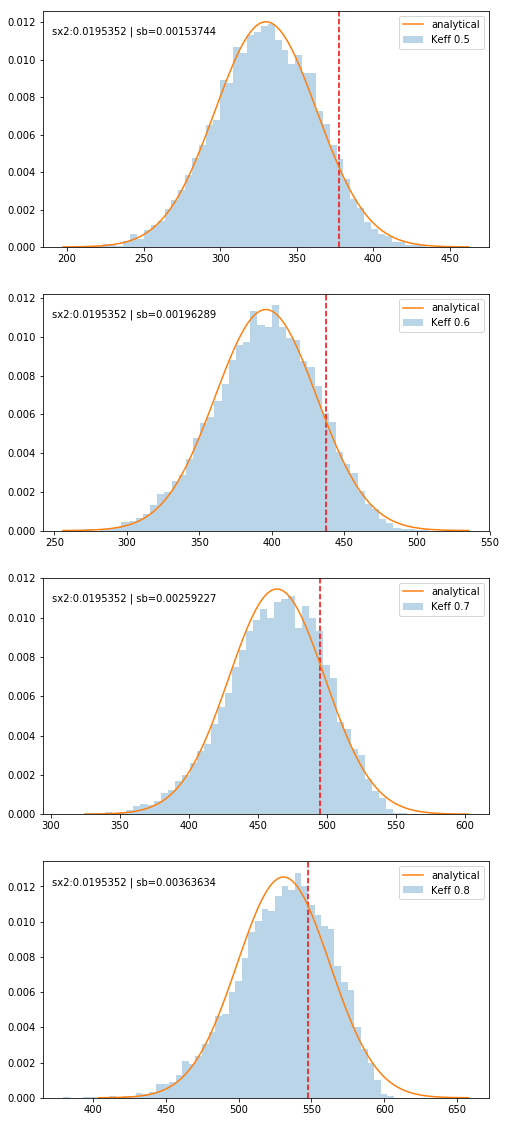

In [376]:
def tejaas_rr_single_SNP(myGT, myGX, sigmax2, sb2, j):
    it = 10000
    nsnps  = myGT.shape[0]
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    Keff   = np.zeros(nsnps)
    randQ  = np.zeros(it)
    
    Yt = myGX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    
    S2mod = S2 + (sigmax2 / sb2)
    Keff = np.sum(S2/S2mod)

    W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2
    Rscore = np.sum(np.square(np.dot(U.T, myGT[j,:])) * (S2 / S2mod)) / sigmax2

    pval, muQ, sigmaQ = pvals_perm(myGT[j, :].reshape(1, -1), Rscore, W)

    rand_gt = copy.deepcopy(myGT[j,:])
    for k in range(it):
        random.shuffle(rand_gt)
        randQ[k] = np.sum(np.square(np.dot(U.T, rand_gt)) * (S2 / S2mod)) / sigmax2      
        
    return pval, Rscore, muQ, sigmaQ, Keff, randQ

def shuffle_single_snp(GX, GT, label, sigmax2, sb2 = None, cismasks = None):
    nsnps  = GT.shape[0]
    Rscore = np.zeros(nsnps)
    pvals  = np.zeros(nsnps)
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    Keff   = np.zeros(nsnps)
    EmuQ   = np.zeros(nsnps)
    EsigmaQ= np.zeros(nsnps)
    myGT = GT
    myGX = GX
    opt_sb2 = np.zeros(nsnps)
    
    print("====== {:s} ======".format(label))
    Yt = myGX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S, dtype=np.float64 )
    
    fig = plt.figure(figsize=(8,20), dpi=72)
    
    KEFFS = [0.5, 0.6, 0.7, 0.8] #[0.7, 0.8, 0.9, 0.99]
    for i, keff in enumerate(KEFFS):
        ax = fig.add_subplot(len(KEFFS),1,i+1)
        sb2 = optimize_sb2(S, sigmax2, keff)
        
        if cismasks is not None:
            nmasks = len(cismasks)
            print("Found {:d} cismasks.".format(nmasks))
            for i,cismask in enumerate(cismasks):
                print("Processing cismask {:d}: {:d} genes masked for {:d} snps".format(i, len(cismask.rmv_id), cismask.nsnp))
                usegenes = np.ones(GX.shape[0], dtype=bool)
                if cismask.rmv_id.shape[0] > 0: usegenes[cismask.rmv_id] = False
                myGX = GX[usegenes]
                myGT = GT[cismask.apply2,:]

    #             SBOPT = SBoptimizer(myGT, myGX, sigmax2[cismask.apply2])
    #             SBOPT.fit()
    #             sb2 = SBOPT.sb2
    #             opt_sb2[cismask.apply2] = SBOPT.sb2

                # Select SNP here based on..
                j = np.argsort(sigmax2)[0]
                print(f"Selected SNP {j} with sb {np.sqrt(sb2[j])}")
                pvals, Q, muQ, sigmaQ, Keff, randQ = tejaas_rr_single_SNP(myGT, myGX, sigmax2[cismask.apply2][j], sb2[j], j)
                print(f"Keff: {keff} | pval: {pvals} | Q:{Q} | sx2:{sigmax2[j]}")
                
                ax.hist(randQ, bins=50, alpha=0.3, density=True, label=f"Keff {keff}")
                ax.axvline(Q, linestyle="--", color="red")

                x = np.linspace(muQ-4*sigmaQ, muQ+4*sigmaQ, 100)
                rv = stats.norm(loc = muQ, scale = sigmaQ)
                ax.plot(x, rv.pdf(x), label = 'analytical')
                
                ax.text(0.02,0.9,f"sx2:{sigmax2[j]:g} | sb={np.sqrt(sb2[j]):g}", transform=ax.transAxes)
                ax.legend()
                
        else:
            print("failed to provide cismask")
            raise
    plt.show()
    return pvals, Q, muQ, sigmaQ, opt_sb2, Keff, randQ

pvals, Q, muQ, sigmaQ, opt_sb2, Keff, randQ               = shuffle_single_snp( gx_knn_norm, 
                                                                                gt_knn_cent,
                                                                                "Norm, KNN",
                                                                                sigmax2_knn,
                                                                                cismasks=cismaskcomp)



In [318]:
minix = np.argsort(sigmax2_knn)[0]
print(sb2_opt_K[minix], sigmax2_knn[minix], minix)

2.8149079975248754e-06 0.01953516992153659 939


0.45223880597014926 341
optimize_sb2 took: 0.225868 seconds
optimize_sb2 took: 0.160172 seconds
optimize_sb2 took: 0.297385 seconds
optimize_sb2 took: 0.406552 seconds
optimize_sb2 took: 0.540846 seconds
optimize_sb2 took: 0.806699 seconds
optimize_sb2 took: 2.951525 seconds


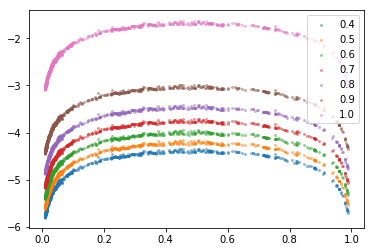

In [172]:


fig = plt.figure()
ax  = fig.add_subplot(111)
for keff in [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    sb2_opt_K = optimize_sb2(S, sigmax2_knn, keff)
    ax.scatter(mafs, np.log10(sb2_opt_K), label=keff, alpha=0.4, s=4)
# ax.set_ylim(0,)
ax.legend()
plt.show()

# Sbeta optimization

In [ ]:
tissue = "wb"
df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue), header=0, index_col=0, sep="\t")
ngene, nsample = df.shape
gx_donors = list(df.columns)
gx = df.values
gene_names = list(df.index)

vcfmask, exprmask = select_donors(gt_donors, gx_donors)
genes, indices = select_genes(geneinfo, gene_names)
dosage_masked = gtfull[:, vcfmask]

snp_info, dosage = filter_snps(snpinfos, dosage_masked)

gx_norm = normalize_expr( gx[:, exprmask] )

## --- Apply KNN correction
f=1
gx_knn, gt_knn = knn_correction(gx_norm.T, dosage, K=30, f=f)

## --- Normalize GX and GT
gt_norm, gt_cent = normalize_and_center_dosage(dosage, snp_info)
sigmax2     = np.var(gt_cent, axis = 1)

gx_knn_norm = normalize_expr(gx_knn.T)
gt_knn_norm, gt_knn_cent = normalize_and_center_dosage(gt_knn, snp_info)
sigmax2_knn = np.var(gt_knn_cent, axis = 1)



In [ ]:
GT = gt_knn_cent
GX = gx_knn_norm
Nsample = GX.shape[1]

cismask = cismaskcomp[0]
print("Processing cismask {:d}: {:d} genes masked for {:d} snps".format(0, len(cismask.rmv_id), cismask.nsnp))
usegenes = np.ones(GX.shape[0], dtype=bool)
if cismask.rmv_id.shape[0] > 0: usegenes[cismask.rmv_id] = False
myGX = GX[usegenes] #/ np.sqrt(Nsample)
myGT = GT[cismask.apply2,:]

Yt = myGX.T
U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
S2  = np.square(S)
YTY = np.matmul(myGX, Yt)

# Gene number
G = myGX.shape[0]

j = 0
print("sx2=",sigmax2_knn[j])
SIGMA_BETAS2 = np.linspace(0.02, 0.034, 10)
# SIGMA_BETAS2 = np.linspace(0.00001, 0.0001, 20)

gridsize   = SIGMA_BETAS2.shape[0]
betax_term = np.zeros(gridsize)
der        = np.zeros(gridsize)
Keff_term  = np.zeros(gridsize)
ML_sb2     = np.zeros(gridsize)
Rscore     = np.zeros(gridsize)
for i,sb2 in enumerate(SIGMA_BETAS2):
    S2mod = S2 + (sigmax2_knn[j] / sb2)
    
    Rscore[i] = np.sum(np.square(np.dot(U.T, myGT[j,:])) * (S2 / S2mod)) / sigmax2_knn[j]
    
    Ig = np.identity(G) * (sigmax2_knn[j] / sb2)
    
##     YTY_Ig = np.log(np.linalg.norm(YTY + Ig, 1))
##     a = np.power(2*np.pi*sb2, G/2) * YTY_Ig
##     b = np.exp(Rscore[i] / (2*sigmax2_knn[j]))
    L_YTY_Ig = np.linalg.cholesky(YTY + Ig)
    det_YTY_Ig = 2*np.log(np.trace(L_YTY_Ig))
    log_a = -(G/2)*np.log(2*np.pi*sb2) - 0.5*det_YTY_Ig
#     log_a = (-G)*np.log(sb2) + G*np.log(sigmax2_knn[j]) - 0.5*YTY_Ig
    
    
    log_b = Rscore[i] / (2*sigmax2_knn[j])
    ML_sb2[i] = log_a + log_b
    print(ML_sb2[i])

    Keff_term[i] = np.sum(S2/S2mod)
    betax_term[i] = np.sum(np.square(np.dot(U.T, myGT[j,:])) * (S2 / S2mod)) / sb2
    der[i]    = ( -Keff_term[i] + betax_term[i] ) / ( 2 * sb2 )

In [ ]:
S2mod = S2 + (sigmax2_knn[j] / sb2)
Keff_term[i] = np.sum(S2/S2mod)

In [ ]:
GT = gt_knn_cent
GX = gx_knn_norm
Nsample = GX.shape[1]

cismask = cismaskcomp[0]
print("Processing cismask {:d}: {:d} genes masked for {:d} snps".format(0, len(cismask.rmv_id), cismask.nsnp))
usegenes = np.ones(GX.shape[0], dtype=bool)
if cismask.rmv_id.shape[0] > 0: usegenes[cismask.rmv_id] = False
myGX = GX[usegenes] #/ np.sqrt(Nsample)
myGT = GT[cismask.apply2,:]

Yt = myGX.T
U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
S2  = np.square(S)
YTY = np.matmul(myGX, Yt)

# Gene number
G = myGX.shape[0]

j = 0
print("sx2=",sigmax2_knn[j])
SIGMA_BETAS2 = np.linspace(1.47e-07, 1.48e-7, 100)
# SIGMA_BETAS2 = np.linspace(0.027, 0.036, 10)
# SIGMA_BETAS2 = np.linspace(1, 2*Nsample, 100)

gridsize   = SIGMA_BETAS2.shape[0]
betax_term = np.zeros(gridsize)
der        = np.zeros(gridsize)
der_old    = np.zeros(gridsize)
Keff_term  = np.zeros(gridsize)
ML_sb2     = np.zeros(gridsize)
Rscore     = np.zeros(gridsize)
I = np.identity(Nsample)
for i,sb2 in enumerate(SIGMA_BETAS2):
    S2mod = S2 + (sigmax2_knn[j] / sb2)
    Rscore[i] = np.sum(np.square(np.dot(U.T, myGT[j,:])) * (S2 / S2mod)) / sigmax2_knn[j]
    ML_sb2[i] = -0.5*np.sum(np.log( S2 * (sb2 / sigmax2_knn[j]) + 1 )) + 0.5*Rscore[i]
    
#     # Gradient check, it matches
#     delta = 0.000001
#     newsb2 = sb2 + delta
#     newS2mod = S2 + (sigmax2_knn[j] / newsb2)
#     newR = np.sum(np.square(np.dot(U.T, myGT[j,:])) * (S2 / S2mod)) / sigmax2_knn[j]
#     newM = -0.5*np.sum(np.log( S2 * (newsb2 / sigmax2_knn[j]) + 1 )) + 0.5*newR
#     M_grad = (newM - ML_sb2[i]) / delta
#     print(M_grad)
        
    denom = (S2 * sb2 + sigmax2_knn[j])
    der[i] = 0.5* np.sum( ( S2 / denom ) * ( (np.square(np.dot(U.T, myGT[j,:])) / denom ) - 1 ) )

#     ## -- der_old below is equal to der above, good! it matches!
#     Keff_term[i]  = np.sum(S2/S2mod)
#     ## alternative check for beta term
#     innerLinv_ST = (S*I / (S2*I + (sigmax2_knn[j]/sb2))) * I
#     UT = np.transpose(U)
#     V = np.transpose(Vt)
#     innerLinv_STUT = np.matmul(innerLinv_ST, UT)
#     A2 = np.matmul(V, innerLinv_STUT)
#     Bi = np.matmul(A2, myGT[j,:][np.newaxis].T)
#     B2 = np.dot(Bi.T, Bi)

#     betax_term[i] = B2 / sb2
    # der_old[i]    = ( -Keff_term[i] + betax_term[i] ) / ( 2 * sb2 )

In [ ]:
from scipy.optimize import minimize


GT = gt_knn_cent
GX = gx_knn_norm
Nsample = GX.shape[1]

cismask = cismaskcomp[0]
print("Processing cismask {:d}: {:d} genes masked for {:d} snps".format(0, len(cismask.rmv_id), cismask.nsnp))
usegenes = np.ones(GX.shape[0], dtype=bool)
if cismask.rmv_id.shape[0] > 0: usegenes[cismask.rmv_id] = False
myGX = GX[usegenes] #/ np.sqrt(Nsample)
myGT = GT[cismask.apply2,:]


class SBoptimizer:

    def __init__(self, GT, GX, sx2):

        self._GT  = np.ascontiguousarray(GT)
        self._GX  = np.ascontiguousarray(GX)
        self._sx2 = np.ascontiguousarray(sx2)
        self._nsnps = GT.shape[0]
        self._nsample = GX.shape[1]
        
        U, S, VT = np.linalg.svd(GX.T)
        self._S = S
        self._U = U
        self._S2 = np.square(S)
        self._opt_sb2 = np.zeros(self._nsnps)
    
    @property
    def sb2(self):
        return self._opt_sb2

    def get_ML(self, _sb2, i):
        # sb2 = sb * sb
        sb2 = np.exp(_sb2)
        S2mod = self._S2 + (self._sx2[i] / sb2)
        Rscore = np.sum(np.square(np.dot(self._U.T, self._GT[i,:])) * (self._S2 / S2mod)) / self._sx2[i]
        MLL = -0.5*np.sum(np.log( self._S2 * (sb2 / self._sx2[i]) + 1 )) + 0.5*Rscore

        denom = (self._S2 * sb2 + self._sx2[i])
        der = 0.5* np.sum( ( self._S2 / denom ) * ( (np.square(np.dot(self._U.T, self._GT[i,:])) / denom ) - 1 ) )
        return -MLL, sb2*np.array([-der])

    def fit(self):
        st = time.time()
        
        sb_init = np.exp(0.01)
        for i in range(self._nsnps):
            res = minimize(   self.get_ML,
                              sb_init, 
                              args = i,
                              method='L-BFGS-B',
                              jac = True,
                              #bounds = [[0,1]],
                              options={'maxiter': 200000,
                                       'maxfun': 2000000,
                                       #'ftol': 1e-9,
                                       #'gtol': 1e-9,
                                       'disp': True})

            print(res)
            self._opt_sb2[i] = np.exp(res.x[0])
        et = time.time()
        print("optimization took in total: ",et-st)
        
# GT was subsetted above
SBOPT = SBoptimizer(myGT, myGX, sigmax2_knn[cismask.apply2])
        
# Yt = myGX.T
# U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
# S2  = np.square(S)

# def get_ML(sb2, S, S2, U, GT, sx2, i):
#     S2mod = S2 + (sx2[i] / sb2)
#     Rscore = np.sum(np.square(np.dot(U.T, GT[i,:])) * (S2 / S2mod)) / sx2[i]
#     MLL = -0.5*np.sum(np.log( S2 * (sb2 / sx2[i]) + 1 )) + 0.5*Rscore
            
#     denom = (S2 * sb2 + sx2[i])
#     der = 0.5* np.sum( ( S2 / denom ) * ( (np.square(np.dot(U.T, GT[i,:])) / denom ) - 1 ) )
#     return -MLL, -der

# lml_min = optimize.minimize(self._log_marginal_likelihood,
#                                         scaledparams,
#                                         method='L-BFGS-B',
#                                         jac=True,
#                                         bounds=bounds,
#                                         callback=self._callback_zstates,
#                                         options={'maxiter': 200000,
#                                                  'maxfun': 2000000,
#                                                  'ftol': 1e-9,
#                                                  'gtol': 1e-9,
#                                                  'disp': True})

In [ ]:
SBOPT.fit()

In [ ]:
SBOPT.sb2

In [ ]:
plt.hist(np.sqrt(SBOPT.sb2), bins=20)
plt.show()

In [ ]:
fig = plt.figure(figsize=(14,8))
ax1  = fig.add_subplot(121)
ax2  = fig.add_subplot(122)

SIGMA_BETAS = SIGMA_BETAS2
ax1.scatter(SIGMA_BETAS,  ML_sb2, label="log_ML", c="blue")
ax1.scatter(SIGMA_BETAS,  der, label="log_derivative", c='red')
ax1.axhline(0, ls="--", c="red")
ax1.set_xlabel(r"$\sigma_{\beta}^2$")
ax1.set_xlim(min(SIGMA_BETAS), max(SIGMA_BETAS))
# ax1.set_xlim(0.025,0.03)
# ax1.set_ylim(0,10)

ax2.scatter(SIGMA_BETAS, Keff_term, label=r"$K_{eff}$")
ax2.scatter(SIGMA_BETAS, betax_term, label=r"$ \beta $")
ax2.axhline(GX.shape[1], c="red")
ax2.set_xlabel(r"$\sigma_{\beta}^2$")
ax2.set_xlim(min(SIGMA_BETAS), max(SIGMA_BETAS))
ax2.legend()
ax2.set_ylim(0,1000)

ax1.legend()
plt.show()

In [ ]:
print(der)
print(ML_sb2)

# Singular values of some tissues

optimize_sb2 took: 0.600256 seconds
Tissue: as
Q:518.7865548980432 | sx2:0.02207362685723634 | sb2:1.3456460199101155e-05
optimize_sb2 took: 0.658385 seconds
Tissue: ms
Q:626.3981491823943 | sx2:0.023877767434312303 | sb2:2.053440462276875e-05
optimize_sb2 took: 0.624858 seconds
Tissue: sse
Q:540.8848768333919 | sx2:0.02594420842535043 | sb2:1.7152595160862455e-05
optimize_sb2 took: 0.588584 seconds
Tissue: ag
Q:211.2111834785212 | sx2:0.0377803156358665 | sb2:2.4893508460944007e-05
optimize_sb2 took: 0.814106 seconds
Tissue: wb
Q:611.1773325140085 | sx2:0.029594505086507766 | sb2:5.411440681907765e-05


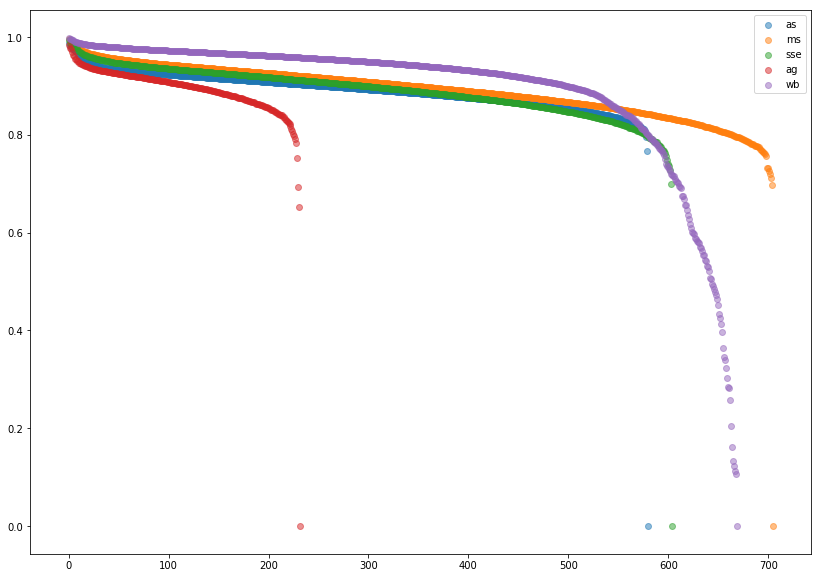

In [290]:
select_tissues = ["as", "ms", "sse", "ag", "wb"]

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(111)

for tissue in select_tissues:
    df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess_dec2019_nopc/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue), header=0, index_col=0, sep="\t")
    ngene, nsample = df.shape
    gx_donors = list(df.columns)
    gx = df.values
    gene_names = list(df.index)
    
    vcfmask, exprmask = select_donors(gt_donors, gx_donors)
    genes, indices = select_genes(geneinfo, gene_names)
    dosage_masked = gtfull[:, vcfmask]

    snp_info, dosage = filter_snps(snpinfos, dosage_masked)

    gx_norm = normalize_expr( gx[:, exprmask] )

    ## --- Apply KNN correction
    f=1
    gx_knn, gt_knn = knn_correction(gx_norm.T, dosage, K=30, f=f)

    ## --- Normalize GX and GT
    gt_norm, gt_cent = normalize_and_center_dosage(dosage, snp_info)
    sigmax2     = np.var(gt_cent, axis = 1)

    gx_knn_norm = normalize_expr(gx_knn.T)
    gt_knn_norm, gt_knn_cent = normalize_and_center_dosage(gt_knn, snp_info)
    sigmax2_knn = np.var(gt_knn_cent, axis = 1)
    
    Y = gx_knn_norm # / np.sqrt(nsample)
    Yt = Y.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    
    #ax1.scatter(np.arange(len(S)), S, label=tissue, alpha=0.5)
    
    sb2 = optimize_sb2(S=S, sigmasx=sigmax2_knn, target=0.9)
    i = 0
    S2 = np.square(S)
    S2mod = S2 + (sigmax2_knn[i] / sb2[i])
    Keff_comp = S2/S2mod

    W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2_knn[i]
    Rscore = np.sum(np.square(np.dot(U.T, gt_knn_cent[i,:])) * (S2 / S2mod)) / sigmax2_knn[i]
    print(f"Tissue: {tissue}")
    print(f"Q:{Rscore} | sx2:{sigmax2_knn[i]} | sb2:{sb2[i]}")
    
    ax1.scatter(np.arange(len(Keff_comp)), Keff_comp, label=tissue, alpha=0.5)
    
ax1.legend()
plt.show()

Tissue: as
optimize_sb2 took: 0.146746 seconds
Q:4.057374579083447 | sx2:0.017968742439638072 | sb2:8.611055617141386e-07 | Keff:0.4 | UTx:10.43983935742972 
optimize_sb2 took: 0.015903 seconds
Q:5.047250992698017 | sx2:0.017968742439638072 | sb2:1.2910104078617304e-06 | Keff:0.5 | UTx:10.43983935742972 
optimize_sb2 took: 0.151295 seconds
Q:5.943706359434094 | sx2:0.017968742439638072 | sb2:1.851556672126805e-06 | Keff:0.6 | UTx:10.43983935742972 
optimize_sb2 took: 0.210964 seconds
Q:7.008122061997042 | sx2:0.017968742439638072 | sb2:2.910090274256041e-06 | Keff:0.7 | UTx:10.43983935742972 
optimize_sb2 took: 0.262727 seconds
Q:8.081582622944978 | sx2:0.017968742439638072 | sb2:4.966051246139066e-06 | Keff:0.8 | UTx:10.43983935742972 
optimize_sb2 took: 0.382478 seconds
Q:9.201475587973086 | sx2:0.017968742439638072 | sb2:1.0954052500331277e-05 | Keff:0.9 | UTx:10.43983935742972 


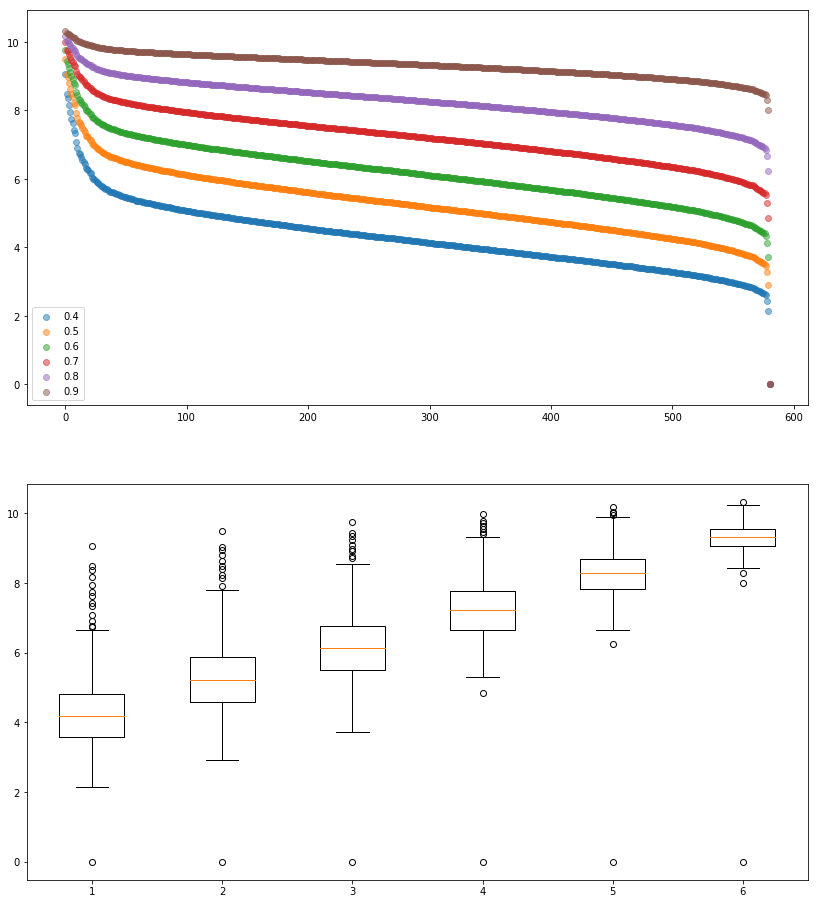

In [79]:

fig = plt.figure(figsize=(14,16))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

tissue = "as"
df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess_dec2019_nopc/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue), header=0, index_col=0, sep="\t")
ngene, nsample = df.shape
gx_donors = list(df.columns)
gx = df.values
gene_names = list(df.index)

vcfmask, exprmask = select_donors(gt_donors, gx_donors)
genes, indices = select_genes(geneinfo, gene_names)
dosage_masked = gtfull[:, vcfmask]

snp_info, dosage = filter_snps(snpinfos, dosage_masked)

gx_norm = normalize_expr( gx[:, exprmask] )

## --- Apply KNN correction
f=1
gx_knn, gt_knn = knn_correction(gx_norm.T, dosage, K=30, f=f)

## --- Normalize GX and GT
gt_norm, gt_cent = normalize_and_center_dosage(dosage, snp_info)
sigmax2     = np.var(gt_cent, axis = 1)

gx_knn_norm = normalize_expr(gx_knn.T)
gt_knn_norm, gt_knn_cent = normalize_and_center_dosage(gt_knn, snp_info)
sigmax2_knn = np.var(gt_knn_cent, axis = 1)

Y = gx_knn_norm # / np.sqrt(nsample)
Yt = Y.T
U, S, Vt = np.linalg.svd(Yt, full_matrices=False)

#ax1.scatter(np.arange(len(S)), S, label=tissue, alpha=0.5)
print(f"Tissue: {tissue}")
components = list()
for keff in [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    sb2 = optimize_sb2(S=S, sigmasx=sigmax2_knn, target=keff)
    i = np.argsort(sigmax2_knn)[0]
    S2 = np.square(S)
    S2mod = S2 + (sigmax2_knn[i] / sb2[i])
    
    UTx = np.sum(np.square(np.dot(U.T, gt_knn_cent[i,:])))
    Keff_comp = S2/S2mod * UTx

    W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2_knn[i]
    Rscore = np.sum(np.square(np.dot(U.T, gt_knn_cent[i,:])) * (S2 / S2mod)) #/ sigmax2_knn[i]
    
    
    print(f"Q:{Rscore} | sx2:{sigmax2_knn[i]} | sb2:{sb2[i]} | Keff:{keff} | UTx:{UTx} ")
    
    ax1.scatter(np.arange(len(Keff_comp)), Keff_comp, label=keff, alpha=0.5)
    components.append(Keff_comp)
ax2.boxplot(components)    
ax1.legend()
plt.show()

In [110]:

# fig = plt.figure(figsize=(14,10))
# ax1 = fig.add_subplot(111)

tissue = "wb"
df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess_dec2019_nopc/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue), header=0, index_col=0, sep="\t")
ngene, nsample = df.shape
gx_donors = list(df.columns)
gx = df.values
gene_names = list(df.index)

vcfmask, exprmask = select_donors(gt_donors, gx_donors)
genes, indices = select_genes(geneinfo, gene_names)
dosage_masked = gtfull[:, vcfmask]

snp_info, dosage = filter_snps(snpinfos, dosage_masked)

gx_norm = normalize_expr( gx[:, exprmask] )

## --- Apply KNN correction
f=1
gx_knn, gt_knn = knn_correction(gx_norm.T, dosage, K=30, f=f)

## --- Normalize GX and GT
gt_norm, gt_cent = normalize_and_center_dosage(dosage, snp_info)
sigmax2     = np.var(gt_cent, axis = 1)

gx_knn_norm = normalize_expr(gx_knn.T)
gt_knn_norm, gt_knn_cent = normalize_and_center_dosage(gt_knn, snp_info)
sigmax2_knn = np.var(gt_knn_cent, axis = 1)

Y = gx_knn_norm # / np.sqrt(nsample)
Yt = Y.T
U, S, Vt = np.linalg.svd(Yt, full_matrices=False)

#ax1.scatter(np.arange(len(S)), S, label=tissue, alpha=0.5)
print(f"Tissue: {tissue}")
it = 1000000

randQs  = list()
Rscores = list()

ix = list()
for t in [0.01, 0.05, 0.1]:
    j = np.argsort(np.abs(sigmax2_knn - t))[0]
    ix.append(j)
    print(sigmax2_knn[j])

for keff in [0.4, 0.5, 0.6, 0.7, 0.8, 0.95, 0.98]:
    for i in ix:
        randQ   = np.zeros(it)
        sb2 = optimize_sb2(S=S, sigmasx=sigmax2_knn, target=keff)
        i = np.argsort(sigmax2_knn)[0]
        S2 = np.square(S)
        S2mod = S2 + (sigmax2_knn[i] / sb2[i])

        rand_gt = copy.deepcopy(gt_knn_cent[i,:])
        for k in range(it):
            random.shuffle(rand_gt)
            randQ[k] = np.sum(np.square(np.dot(U.T, rand_gt)) * (S2 / S2mod)) / sigmax2_knn[i]  
        randQs.append(randQ)
        Rscore = np.sum(np.square(np.dot(U.T, gt_knn_cent[i,:])) * (S2 / S2mod)) / sigmax2_knn[i]    
        Rscores.append(Rscore)

Tissue: wb
0.01953516992153659
0.049682968243360305
0.09992173708571571
optimize_sb2 took: 0.126208 seconds
optimize_sb2 took: 0.129525 seconds
optimize_sb2 took: 0.128234 seconds
optimize_sb2 took: 0.093190 seconds
optimize_sb2 took: 0.114652 seconds
optimize_sb2 took: 0.092293 seconds
optimize_sb2 took: 0.166196 seconds
optimize_sb2 took: 0.166209 seconds
optimize_sb2 took: 0.166703 seconds
optimize_sb2 took: 0.257591 seconds
optimize_sb2 took: 0.225583 seconds
optimize_sb2 took: 0.226486 seconds
optimize_sb2 took: 0.292236 seconds
optimize_sb2 took: 0.291788 seconds
optimize_sb2 took: 0.289587 seconds
optimize_sb2 took: 0.580779 seconds
optimize_sb2 took: 0.588661 seconds
optimize_sb2 took: 0.584750 seconds
optimize_sb2 took: 0.839177 seconds
optimize_sb2 took: 0.839238 seconds
optimize_sb2 took: 1.030357 seconds


In [115]:
len(S)

670

In [111]:
tmp = np.array(randQs)
np.savetxt("Qscores_distributions.txt", tmp, delimiter=" ")

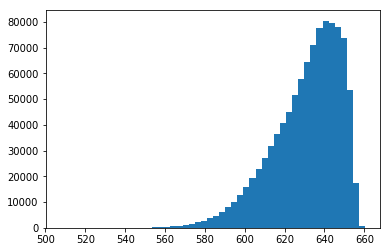

In [114]:
plt.hist(tmp[15,:], bins=50)
plt.show()